# Illustrations of Phonlab library

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import parselmouth
from IPython.display import Audio
import importlib

cwd = os.getcwd()
sys.path.insert(0, os.path.abspath(os.path.dirname(cwd)))

import phonlab as phon

importlib.reload(phon)
print(phon.__name__,phon.__version__)

phonlab 0.0.30


## de Krom's Harmonics-to-Noise technique

2.1, 0.0565625, 88.39779005524862, 16.838621962536344, 20.026818405878604
T0[fn] = 181, 11.375


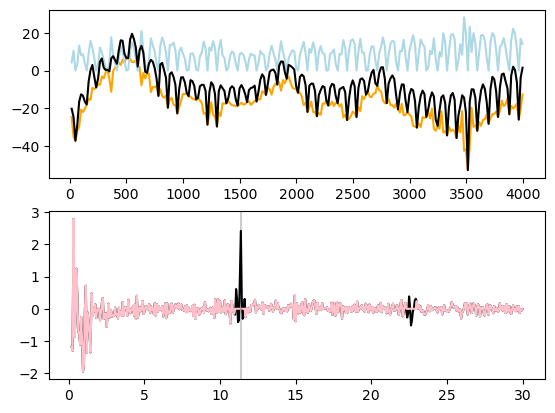

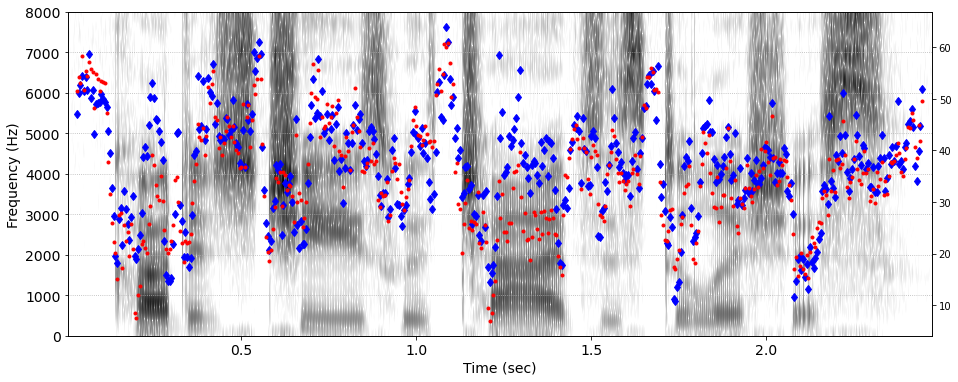

In [4]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/sf3_cln.wav'
x,fs = phon.loadsig(example_file,chansel=[0])

df = phon.HNR(x,fs, target_time=2.1)

# ---- Now plot the results -------
ret = phon.sgram(x,fs,cmap="Grays") # draw a spectrogram of the sound
ax2 = ret[0].twinx() 
ax2.plot(df.sec,df.hnr_500,'bd')
ax2.plot(df.sec,df.hnr_1500,'r.')


## H2H1

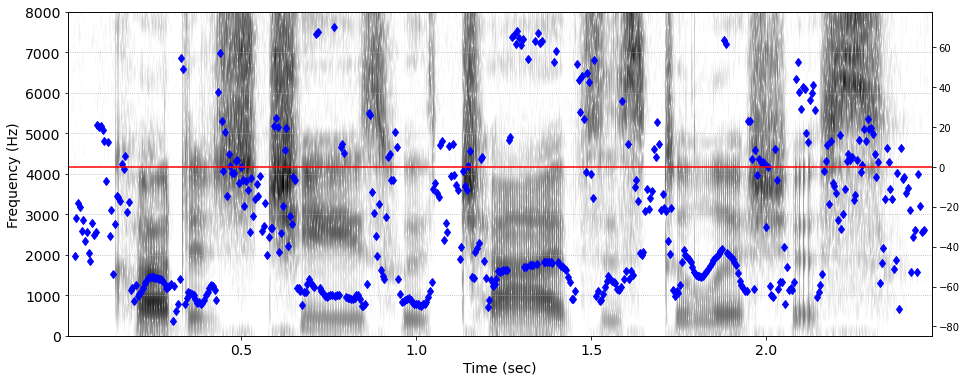

In [2]:

example_file = importlib.resources.files('phonlab') / 'data/example_audio/sf3_cln.wav'
x,fs = phon.loadsig(example_file,chansel=[0])

x,fs = phon.prep_audio(x, fs, target_fs=16000, pre = 0, quiet=True)  # resample, preemphasis
resid,fs = phon.lpcresidual(x,fs)
f0df = phon.get_f0(x,fs)

df = phon.h2h1(resid,fs,f0df)  # <- using information from lpcresidual(), and get_f0_ac()

# ---- Now plot the results -------
ret = phon.sgram(x,fs,cmap="Grays") # draw a spectrogram of the sound
ax2 = ret[0].twinx() 
ax2.plot(df.sec,df.h2h1,'bd')
ax2.axhline(0,color="red")  # Drugman et al. use 0dB as the threshold for creaky voice


shift from ∆F = 1100 (blue) to new ∆F = 990 (orange)


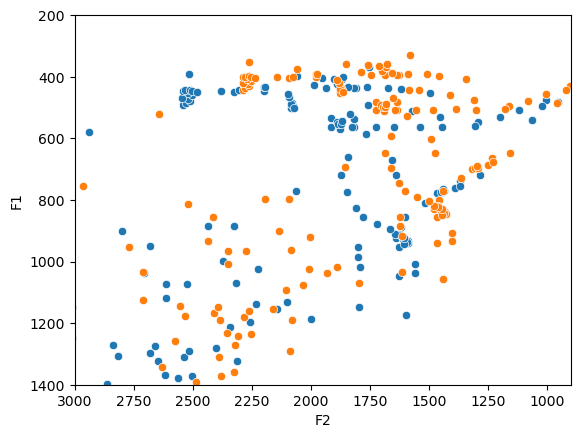

In [3]:

# ----------  Example of using resize_vt() ---------------
example_file = importlib.resources.files('phonlab') / 'data/example_audio/sf3_cln.wav'
x,fs = phon.loadsig(example_file,chansel=[0])

df = phon.track_formants(x, fs,quiet=True)
phon.deltaF_norm(df,deltaF=1100)

deltaf = df['deltaF'][0]
new_deltaf = 0.9 * deltaf  # with a smaller vocal tract, the formants will be shifted toward 0
print(f'shift from ∆F = {deltaf:0.0f} (blue) to new ∆F = {new_deltaf:0.0f} (orange)')

fmtsdf = phon.resize_vt(df,new_deltaf)

ax = sns.scatterplot(fmtsdf,x='F2',y='F1')
sns.scatterplot(fmtsdf,x='new_F2',y='new_F1',ax=ax)
ax.set_xlim(left=3000, right=900)
ax.set_ylim(bottom=1400, top=200);

## Compare execution time of F0 functions

In [4]:
import timeit

example_file = importlib.resources.files('phonlab') / 'data/example_audio/sf3_cln.wav'
x,fs = phon.loadsig(example_file,chansel=[0])
dur = len(x)/fs
print(f"duration of the audio is: {dur}")

resid,fs = phon.lpcresidual(x,fs)
f0df = phon.get_f0(x,fs)

df = phon.h2h1(resid,fs,f0df)  # <- using information from lpcresidual(), and get_f0_ac()

n=10
d = timeit.timeit(stmt='resid,fs2 = phon.lpcresidual(x,fs)',globals=globals(),number=n)
print(f" lpcresidual: {d/dur/n:0.3f} seconds per second of audio")

d = timeit.timeit(stmt='df = phon.get_f0(x,fs)', globals=globals(), number=n)
print(f" ac: {d/dur/n:0.3f} seconds per second of audio")

d = timeit.timeit(stmt='df = phon.CPP(x,fs)', globals=globals(), number=n)
print(f" cpp: {d/dur/n:0.3f} seconds per second of audio")

d = timeit.timeit(stmt='df,mbs,res = phon.gci_sedreams(x,fs)', globals=globals(), number=n)
print(f" gci: {d/dur/n:0.3f} seconds per second of audio")

d = timeit.timeit(stmt='df = phon.get_f0_acd(x,fs)', globals=globals(), number=n)
print(f" acd: {d/dur/n:0.3f} seconds per second of audio")

d = timeit.timeit(stmt='df = phon.get_f0_srh(resid,fs,isResidual=True)', globals=globals(), number=n)
print(f" srh: {d/dur/n:0.3f} seconds per second of audio")

d=timeit.timeit(stmt='df = phon.h2h1(resid,fs,f0df)',globals=globals(),number=n) 
print(f" h2h1: {d/dur/n:0.3f} seconds per second of audio")


duration of the audio is: 2.4768125
 lpcresidual: 0.015 seconds per second of audio
 ac: 0.011 seconds per second of audio
 cpp: 0.012 seconds per second of audio
 gci: 0.016 seconds per second of audio
 acd: 0.028 seconds per second of audio
 srh: 0.030 seconds per second of audio
 h2h1: 0.044 seconds per second of audio


## compare F0 trackers

median f0 =229.5, f0_range=[90, 361]
median f0 =183.9080459770115


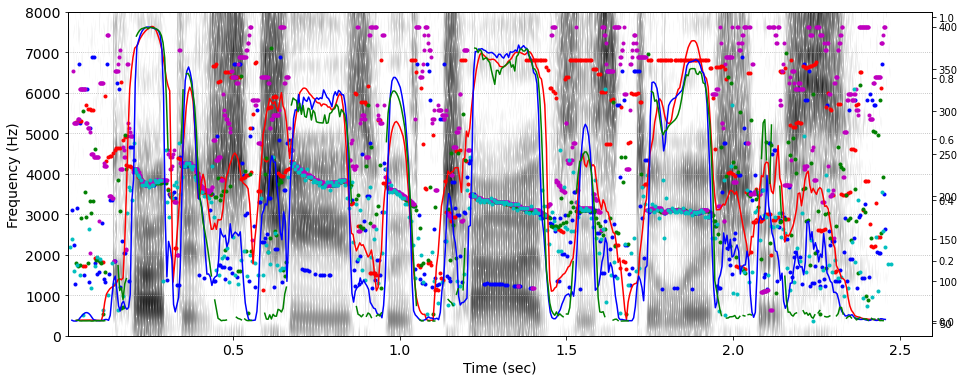

In [49]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/sf3_cln.wav'
x,fs = phon.loadsig(example_file, chansel=[0])
f0_range=[90,400]

f0srh = phon.get_f0_srh(x,fs,f0_range=f0_range)
f0med = np.nanmedian(f0srh.f0)
print(f"median f0 ={f0med}, f0_range={f0_range}")

f0ac = phon.get_f0(x,fs,f0_range=f0_range)
f0cpp = phon.CPP(x,fs)
f0acd = phon.get_f0_acd(x,fs)

f0med = np.nanmedian(f0ac.f0)
print(f"median f0 ={f0med}")

gci_df, mbs,resid = phon.gci_sedreams(x,fs,f0med, cthresh = 0.0)

ret = phon.sgram(x,fs,cmap="Grays") # draw a spectrogram of the sound
ax2 = ret[0].twinx()  # and twin it for plotting f0
ax2.plot(f0ac.sec,f0ac.f0,'b.')
ax2.plot(f0srh.sec,f0srh.f0,'r.')
ax2.plot(f0acd.sec,f0acd.f0,'g.')
ax2.plot(f0cpp.sec,f0cpp.f0,'m.')
ax2.plot(gci_df.sec, gci_df.f0, 'c.')

ax3 = ret[0].twinx()
ax3.plot(f0srh.sec,f0srh.probv,"r-")
ax3.plot(f0ac.sec,f0ac.probv,"b-")
ax3.plot(f0acd.sec,f0acd.probv,"g-")


## Mel frequency spectrogram

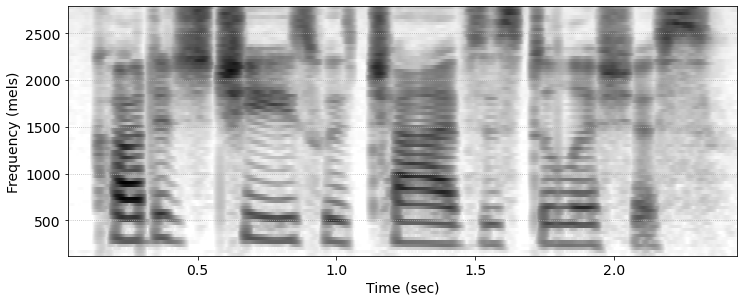

In [28]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/sf3_cln.wav'
x,fs = phon.loadsig(example_file,chansel=[0])

mel_f, sec, Sxx = phon.compute_mel_sgram(x,fs,s=0.001)

vmin = np.min(Sxx) + (np.max(Sxx)-np.min(Sxx))*0.2

fig = plt.figure(figsize=(12, 4.5),dpi=72)
ax1 = fig.add_subplot(111)

extent = (min(sec),max(sec),min(mel_f),max(mel_f))  # get the time and frequency values for indices.
ax1.imshow(Sxx.T, aspect='auto', interpolation='nearest', cmap='Grays', vmin=vmin,
                extent = extent, origin='lower')
ax1.grid(which='major', axis='y', linestyle=':')  # add grid lines
ax1.set_xlabel("Time (sec)", size=14)
ax1.set_ylabel("Frequency (mels)", size=14)
plt.tick_params(labelsize=14)

## Cepstrogram

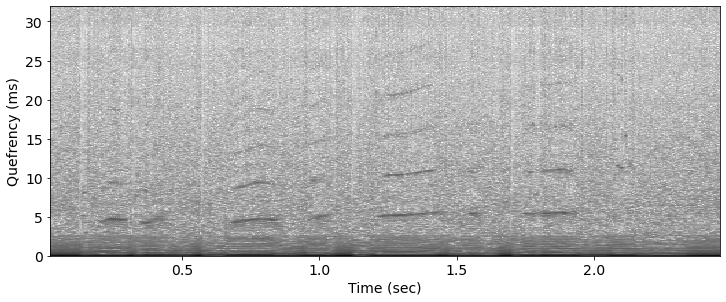

In [29]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/sf3_cln.wav'
x,fs = phon.loadsig(example_file,chansel=[0])

f,sec,Sxx = phon.compute_cepstrogram(x,fs)

vmin = np.min(Sxx) + (np.max(Sxx)-np.min(Sxx))*0.2

fig = plt.figure(figsize=(12, 4.5),dpi=72)
ax1 = fig.add_subplot(111)

extent = (min(sec),max(sec),min(f),max(f))  # get the time and frequency values for indices.
ax1.imshow(Sxx.T, aspect='auto', interpolation='nearest', cmap='Grays', vmin=vmin,
                extent = extent, origin='lower')
ax1.grid(which='major', axis='y', linestyle=':')  # add grid lines
ax1.set_xlabel("Time (sec)", size=14)
ax1.set_ylabel("Quefrency (ms)", size=14)
plt.tick_params(labelsize=14)

## Cepstral peak prominence

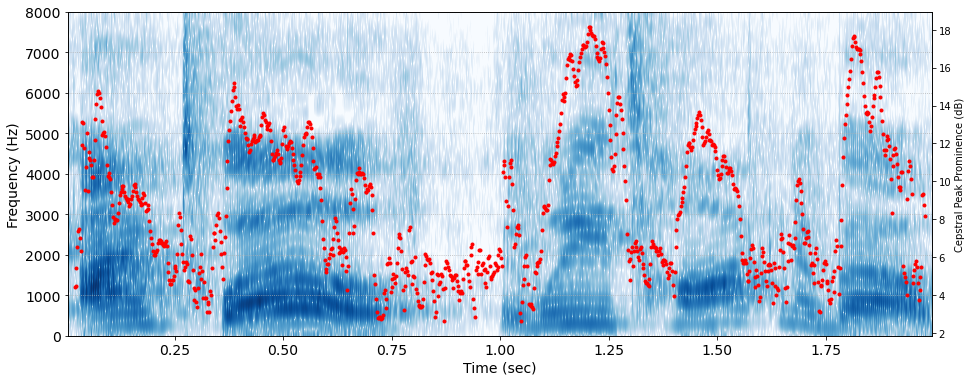

In [31]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/im_twelve.wav'
x,fs = phon.loadsig(example_file,chansel=[0])

cppdf   = phon.CPP(x,fs,smooth=True)
cpp,s,_ = phon.smoothn(cppdf.cpp,s=3,isrobust=True)  # smooth the cpp curve

ret = phon.sgram(x,fs,min_prop = 0.2,cmap="Blues") # draw the spectrogram from the array of samples
ax2 = ret[0].twinx()
ax2.plot(cppdf.sec, cppdf.cpp, 'r.')
plt.ylabel("Cepstral Peak Prominence (dB)")


Audio(x,rate=fs)

In [ ]:


gci_df, mbs,resid = phon.gci_sedreams(x,fs,f0med, cthresh = 0.0)


times = np.array(range(len(x)))/fs

start = 0.35
end = start+0.04
s = int(start*fs)
e = int(end*fs)
plt.plot(times[s:e], x[s:e]+0.75)
plt.plot(times[s:e], mbs[s:e])
plt.plot(times[s:e], resid[s:e],'c-')
plt.vlines(np.ma.masked_outside(gci_df.sec, start,end),0.4,1.1,color='red')
plt.axhline(0.1)
plt.axhline(-0.1)

## Compute the LPC residual

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/sf3_cln.wav'
x,fs = phon.loadsig(example_file, chansel=[0])
x,fs = phon.prep_audio(x, fs, target_fs=16000, pre = 0, quiet=True)  # resample, preemphasis
resid,fs = phon.lpcresidual(x,fs)

start = 11000
end = start + 500
plt.plot(x[start:end])
plt.plot(-0.3 + resid[start:end])

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/im_twelve.wav'
x,fs = phon.loadsig(example_file, chansel=[0])
f0_srh,f0_range = phon.get_f0_srh(x,fs,vthresh=0.03)
f0_srh.loc[f0_srh["voiced"] == False, ("f0")] = np.nan # ignore voiceless regions

f0_B93 = phon.get_f0_B93(x, fs)
f0_B93.loc[f0_B93["voiced"] == False, ("f0","HNR")] = np.nan # ignore nonvocalic formants


ret = phon.sgram(x,fs,cmap="Grays") # draw a spectrogram of the sound
ax2 = ret[0].twinx()  # and twin it for plotting f0
ax2.plot(f0_srh.sec, f0_srh.f0, 'bo')
ax2.plot(f0_B93.sec, f0_B93.f0, 'g+')
ax2.set_ylim(f0_range)

np.nanmedian(f0_srh[f0_srh["srh"]<0.1].f0)

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/fricatives.wav'
x,fs = phon.loadsig(example_file, chansel=[0])
if fs>32000: target_fs=32000
else: target_fs = fs
y,fs = phon.prep_audio(x,fs, target_fs = target_fs, outtype = 'int')

frics_list = {"/f/": 0.322, "/θ/": 1.235, "/s/": 2.158, "/ʃ/": 3.214, "/x/": 4.189, "/h/": 5.06}

fig,axes = plt.subplots(nrows=3,ncols=2,sharex="all",sharey="all")
print(axes.shape)

row = col = 0
for key,value in frics_list.items():
    Fm,Am,AmpD,Fsec,Asec,mode,COG,SD,Skew,Kurtosis,spec,freq = phon.fricative(y,fs,value)

    ax = axes[row][col]
    ax.plot(freq,spec)
    ax.axvline(Fm,color="red")
    ax.text(15000,62,key)
    ax.text(7250,31,f"COG={COG:.0f}")
    ax.text(7250,24,f"Fm={Fm:.0f}")
    ax.text(7250,17,f"AmpD={AmpD:.0f}")
    if not np.isnan(Fsec): 
        ax.axvline(Fsec,color="red")
    ax.axvline(COG,color="green")
    col = col + 1
    if col>1:
        col=0
        row = row + 1


## Audspec -- zgram

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'sf3_cln.wav'
x,fs = phon.loadsig(example_file,chansel=[0])

aud = phon.Audspec()
aud.make_zgram(x,fs)

# ---- the rest is to make a nice plot ----

fig,ax = plt.subplots(2,figsize=(8,6))

Hz_extent = (min(aud.time_axis), max(aud.time_axis),
      min(aud.fft_freqs), max(aud.fft_freqs))  # time and frequency values for sgram.
ax[0].imshow(20*np.log10(aud.sgram.T),origin='lower', aspect='auto',
         extent=Hz_extent, cmap = plt.cm.Greys)
ax[0].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")
ax[1].imshow(aud.zgram.T,origin='lower', aspect='auto', interpolation="spline36",
         extent=aud.extent, cmap = plt.cm.Purples)
ax[1].set(xlabel="Time (sec)", ylabel="Frequency (Bark)")
fig.tight_layout()

In [ ]:
aud.make_sharpgram()

fig,ax = plt.subplots(1,figsize=(8,3))

ax.imshow(aud.sharpgram.T,origin='lower', aspect='auto',
         extent=aud.extent, interpolation="spline36", cmap = plt.cm.Reds)
ax.set(xlabel="Time (sec)", ylabel="Frequency (Bark)")


In [ ]:
aud.make_tgram()

fig,ax = plt.subplots(1,figsize=(8,3))

ax.imshow(aud.tgram.T,origin='lower', aspect='auto',
         extent=aud.extent, interpolation="spline36", cmap = plt.cm.afmhot)
ax.set(xlabel="Time (sec)", ylabel="Frequency (Bark)")

# testing f0_tracking

In [ ]:

example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'im_twelve.wav'
x,fs = phon.loadsig(example_file, chansel=[0])

f0_range=[60,400]

df = phon.get_f0_B93(x,fs,f0_range=f0_range)
df.loc[df["voiced"] == False, ("f0","HNR")] = np.nan # ignore devoiced frames

df2 = phon.get_f0_acd(x,fs)
df2.loc[df2["voiced"] == False, ("f0","H1H2")] = np.nan # ignore devoiced frames


ret = phon.sgram(x,fs,cmap="Blues") # draw a spectrogram of the sound
ax2 = ret[0].twinx()  # and twin it for plotting f0

ax2.plot(df.sec,df.f0, 'ro',label="B93")
ax2.plot(df2.sec,df2.f0, 'k.',label="acd")  
ax2.legend()
ax2.set_ylim(f0_range)

## Rhythm functions

In [ ]:
x,fs = phon.loadsig("s09003.wav")
slice = x[fs*3:fs*7]

f,Sx = phon.get_rhythm_spectrum(slice,fs)
plt.plot(f,Sx)
plt.xlabel("frequency (Hz)")
Audio(slice,rate=fs)

In [ ]:
x,fs = phon.loadsig("s1202a.wav", chansel=[0])
f,ts,Sxx = phon.rhythmogram(x,fs)  # calculate rhythm spectra over time
         
m = np.mean(Sxx,axis=0)  # the mean spectrum of the file
sd = np.std(Sxx,axis=0)  # the standard deviation of the spectrum
Sxx_thresh = Sxx - (m + 0.5*sd)   # subtract a threshold to find "rhythmic" sections
        
start = 136
end = 166
s = np.int32((start-2) *2)  # start frame, two frames per second
e = np.int32((end-2) *2) # end frame
extent = (start,end,min(f),max(f))  # get the time and frequency values for figure.
         
plt.imshow(Sxx_thresh.T[:,s:e], aspect='auto', extent = extent, 
               origin='lower',cmap="coolwarm",interpolation="spline36")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")

## loadsig() and prep_audio()

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'stereo.wav'

# --------
ret = phon.loadsig(example_file)  # taking just the left channel
fs_orig = ret.pop()
x = ret[0]

# or you can say 

*chans, fs_orig = phon.loadsig(example_file)
x = chans[0]

# or you can say 

x, fs_orig = phon.loadsig(example_file, chansel=[0])

# --------

y,fs = phon.prep_audio(x,fs_orig,outtype='int')
print(np.max(y))

y,fs = phon.prep_audio(x,fs_orig,outtype='float')
print(np.max(y))

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'stereo.wav'

x,fs = phon.loadsig(example_file, chansel=[0])
f0_range = [60,400]

f0df = phon.get_f0_B93(x,fs)
f0df.loc[f0df["voiced"] == False, ("f0")] = np.nan # ignore voiceless frames

f0df1 = phon.get_f0_acd(x,fs,prom=18)
f0df1.loc[f0df1["voiced"]==False, ("f0")] = np.nan # ignore voiceless frames

snd = parselmouth.Sound(str(example_file)).extract_left_channel()  # create a Praat Sound object
pitch = snd.to_pitch()  # create a Praat pitch object
f0df2 = phon.pitch_to_df(pitch)  # convert it into a Pandas dataframe

ret = phon.sgram(x,fs,cmap='Grays') # draw a spectrogram of the sound

ax1 = ret[0]  # get the plot axis
ax2 = ax1.twinx()  # and twin it for plotting f0
ax2.plot(f0df2.sec,f0df2.f0-10, color='chartreuse',marker="s",
         linestyle = "none",label="praat")
ax2.plot(f0df.sec,f0df.f0, color='dodgerblue',marker="d",
         linestyle = "none",label="B93")  
ax2.plot(f0df1.sec,f0df1.f0+10, color='orange',marker="d",
         linestyle='none',label="acd")

ax2.legend(fontsize="x-large")
ax2.set_ylim(f0_range)
ax2.set_ylabel("F0 (Hz)", size=14)
for item in ax2.get_yticklabels(): item.set_fontsize(14)

In [ ]:
xx = np.array([1, 3.5, 0, -2])
np.where(xx>0,True,False)
yy = np.log10(xx,where=np.where(xx>0,True,False),out=np.zeros(xx.shape))
yy

## Smoothing with smoothn()

In [ ]:
# 1-D example
x = np.linspace(0,100,2**6);
y = np.cos(x/10)+(x/50)**2 + np.random.random_sample(len(x))/2;
y[[14, 17, 20]] = [2, 2.5, 3];

z,s,e = phon.smoothn(y); # Regular smoothing
zr,sr,e = phon.smoothn(y,isrobust=True); # Robust smoothing

print(f'regular smoothing factor = {s:.3f}, robust smoothing factor = {sr:.3f}')

plt.subplot(121), 
plt.plot(x,y,'r.')
plt.plot(x,z,'k')
plt.title("Smoothed")

plt.subplot(122)
plt.plot(x,y,'r.')
plt.plot(x,zr,'k')
plt.title("Robust Smoothing")


## phon.track_formants()

Python native code implements both LPC and Inverse Filter Control (IFC) vowel formant tracking. 

IFC doesn't care if the waveform format is float or int

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'sf3_cln.wav'
x,fs = phon.loadsig(example_file, chansel=[0])
fmtsdf = phon.track_formants(x, fs, method='lpc',speaker=2,f0_range=[60,350])

ret = phon.sgram(x,fs, tf=6000, cmap="Reds")  # plot the spectrogram

dot_color = "dodgerblue"
sns.pointplot(fmtsdf,x='sec',y='F1',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F2',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F3',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F4',linestyle='none',native_scale=True,marker=".",color=dot_color)

fmtsdf.head()
fmtsdf.to_csv("sf3_cln.csv",index=False)

In [ ]:
VTL = phon.get_deltaF(fmtsdf, return_value="VTL")
deltaF = phon.get_deltaF(fmtsdf)
print(f'deltaF = {deltaF:.0f}, vocal tract length is {VTL:.2f}')


phon.deltaF_norm(fmtsdf,deltaF = deltaF)
fmtsdf.head()

## phon.sgram()

Makes a pretty good looking spectrogram

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'stereo.wav'

x,fs = phon.loadsig(example_file, chansel=[0])
x,fs = phon.prep_audio(x,fs,target_fs=24000)

phon.sgram(x,fs)

#Audio(example_file)
Audio(x,rate=fs)

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/sf3_cln.wav'
x,fs = phon.loadsig(example_file,chansel=[0])

ret = phon.sgram(x,fs,start=1.5, end=2.0,slice_time=1.615)
ax1 = ret[0]
ax1.axvline(1.71,color="red")

### phon.formant2df

One of the **Tidypraat** routines working with parselmouth to call Praat functions in python

In [ ]:
snd = parselmouth.Sound(str(example_file))  # create a Praat Sound object
maxf = 5500       # use 5000 for men, 6000 for women, 8000 for children
fmnt = snd.to_formant_burg(maximum_formant=maxf)  # create a Praat Formant object
fmntdf = phon.formant_to_df(fmnt, 4, include_bw=False)  # convert it into a Pandas dataframe

sns.pointplot(fmntdf,x='sec',y='F1',linestyle='none',native_scale=True)
sns.pointplot(fmntdf,x='sec',y='F2',linestyle='none',native_scale=True)
sns.pointplot(fmntdf,x='sec',y='F3',linestyle='none',native_scale=True)

fmntdf.head()

## phon.amplitude_envelope()

Here's an intersting application of one of the phonab functions.  Get the amplitude envelope in a low frequency band, and then in a high frequency band.  The difference between them (plotted in red over the spectrogram below) segments the speech into consonant and vowel regions.  Above zero is 'vocalic' and below zero is 'consonantal'.

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'sf3_cln.wav'

x,fs = phon.loadsig(example_file, chansel=[0])

lband, fs_diff = phon.amplitude_envelope(x,fs,bounds=[120,3000],target_fs=12000)
hband, fs_diff = phon.amplitude_envelope(x,fs,bounds=[3000,5999],target_fs=12000)

diff = lband-hband  # the difference in the low and high envelopes
time_axis = np.arange(len(diff))/fs_diff  # a time axis for envelope plotting

ax1,f,t,Sxx = phon.sgram(x,fs,cmap='Blues') # draw the spectrogram from the array of samples

ax2 = ax1.twinx()
ax2.plot(time_axis,diff, color = "red")  # add scaled diff function
ax2.axhline(0) 

Audio(example_file)

### Vocalic

This code block uses the diff[] array plotted above to define a **vocalic** feature, 
and then uses that feature to clean up the formant plot.  This is really only needed for 
nice looking graphs.  Illustrating here the three main formant tracking algorithms.

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'sf3_cln.wav'

# 1) IFC formant tracking
x,fs = phon.loadsig(example_file, chansel=[0])

# 2) Python native LPC formant tracking
fmtsdf = phon.track_formants(x,fs,method='ifc',order = 10, speaker=2)

# 3) Praat LPC formant tracking
snd = parselmouth.Sound(str(example_file))  # create a Praat Sound object
maxf = 6000       # use 5000 for men, 6000 for women, 8000 for children
fmnt = snd.to_formant_burg(maximum_formant=maxf)  # create a Praat Formant object
fmtdf = phon.formant_to_df(fmnt, 4, include_bw=False)  # convert it into a Pandas dataframe

# ------ use "vocalic" to decide which formant measurements to draw --------  # note pre=0 is important here
lband, fs_diff = phon.amplitude_envelope(x,fs,bounds=[120,3000],target_fs=12000)
hband, fs_diff = phon.amplitude_envelope(x,fs,bounds=[3000,5999],target_fs=12000)
diff = lband-hband  # the difference in the low and high envelopes
fmtsdf["vocalic"] = diff[(fmtsdf['sec']*fs_diff).astype(int)]>0.005  # add 'vocalic' to the dataframe
fmtsdf.loc[fmtsdf["vocalic"] == False, ("F1","F2","F3","F4")] = np.nan # ignore nonvocalic formants

phon.sgram(x,fs, cmap="Blues")  # plot the spectrogram

# add formant dots to the spectrogram
dot_color = "red"
sns.pointplot(fmtsdf,x='sec',y='F1',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F2',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F3',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F4',linestyle='none',native_scale=True,marker=".",color=dot_color)

dot_color = "lightgreen"
sns.pointplot(fmtdf,x='sec',y='F1',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtdf,x='sec',y='F2',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtdf,x='sec',y='F3',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtdf,x='sec',y='F4',linestyle='none',native_scale=True,marker=".",color=dot_color)

## phon.fricative()

Implements both major peak analysis and moments analysis.  The spectrum at time 0.635 (the 'ch' in 'cheese') illustrates that the "major peak" is the first well separated peak, not the point of maximum amplitude in the spectrum.

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'sf3_cln.wav'

x,fs = phon.loadsig(example_file, chansel=[0])
print(fs)
x,fs = phon.prep_audio(x,fs, target_fs=22050,outtype = 'int')
print(fs)

Fm,Am,AmpD,Fsec,Asec,mode,COG,SD,Skew,Kurtosis,spec,freq = phon.fricative(x,fs,0.27)

print(f"first major peak at {Fm:.1f}, Center of Gravity is {COG:.1f}")
plt.plot(freq,spec)
plt.axvline(Fm,color="red")
plt.axvline(COG,color="green")

## phon.burst()

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'im_twelve.wav'

x,fs = phon.loadsig(example_file, chansel=[0])  
x,fs = phon.prep_audio(x,fs, target_fs=16000, pre=0.94) # add preemphasis, resample to 22050, ensure correct polarity, and scale to use maximum range

t1 = 0.1
t2 = 0.5

b_time, b_score = phon.burst(x,fs, t1,t2)  # find a stop burst in the span from t1 to t2
print(f"the stop release burst is at time: {b_time:.3f} seconds")
 
ax1,f,t,Sxx = phon.sgram(x,fs,start=t1, end=t2)
ax1.axvline(b_time,color="red")


## phon.egg_to_oq()

With a stereo audio file having audio in the left (channel 0) and electroglottography in the right (channel 1),
this function returns a time axis, f0, and open quotient.


In [ ]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/F1_bha24_1.wav'

egg,audio,fs = phon.loadsig(example_file, chansel=[1,0])  
oqdf = phon.egg_to_oq(egg,fs)  # return open quotient data

f01df = phon.get_f0acd(audio,fs)

# ------ The rest of this example is making a nice plot ---------

time = [i/fs for i in range(audio.size)]  # the times of the audio samples.

start_time = 0.1
end_time = start_time + 0.6

sf = np.abs(oqdf.sec - start_time).argmin()  # closest frame to start_time
ef = np.abs(oqdf.sec - end_time).argmin()      # closest frame to end_time

si = int(oqdf.sec.iloc[sf]*fs)  # index of those frame times
ei = int(oqdf.sec.iloc[ef]*fs)    # in the audio and egg signals

fig = plt.figure()
ax1 =fig.add_subplot(411)
ax1.plot(time[si:ei],audio[si:ei],label="audio")
ax1.set_xlim(start_time,end_time)
ax1.set_xticklabels(([]))
ax1.legend()

ax2 =fig.add_subplot(412,sharex=ax1)
ax2.plot(time[si:ei],egg[si:ei],label="EGG")
ax2.legend()

ax3 =fig.add_subplot(413,sharex=ax1)
ax3.plot(oqdf.sec.iloc[sf:ef],oqdf.OQ.iloc[sf:ef],label="OQ")
ax3.legend()

ax4 =fig.add_subplot(414)
ax4.plot(oqdf.sec.iloc[sf:ef],oqdf.f0.iloc[sf:ef],label="F0")
ax4.set_xlim(start_time,end_time)
ax4.legend()

Audio(audio,rate=fs)

## phon.sine_synth()

With a formants data frame from phon.track_formants(), sine_synth() produces sine wave analogs of speech.

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/sf3_cln.wav'

x,fs = phon.loadsig(example_file)   # illustrating here that we can pass an array to track_formants()
fmtsdf = phon.track_formants(x,fs)    # track the formants

x2,fs2 = phon.sine_synth(fmtsdf)     # use the formants to produce sinewave synthesis
phon.sgram(x2,fs2, band="nb", preemph=0)  # plot a spectrogram of it

Audio(x2,rate=fs2) 

## phon.sigcor_noise()

Replace signal with noise that matches the amplitude envelope of the signal

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/sf3_cln.wav'

x,fs = phon.loadsig(example_file)   # illustrating here that we can pass an array to track_formants()
y,fs = phon.sigcor_noise(x,fs,flip_rate=0.4,start=1.2,end=1.5)

time_axis = np.arange(len(y))/fs
plt.plot(time_axis,y)  # add_noise pads the signal by 0.5 seconds

phon.sgram(y,fs,preemph=0)
Audio(y,rate=fs) 

## phon.add_noise()

A function that can be used to prepare speech in noise (SPIN) stimuli.


In [ ]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/im_twelve.wav'

x,fs = phon.loadsig(example_file)   # illustrating here that we can pass an array to track_formants()
y,fs = phon.add_noise(x,fs,"babble",snr=3)
time_axis = np.arange(len(y))/fs

plt.plot(time_axis - 0.5,y)  # add_noise pads the signal by 0.5 seconds
y,fs = phon.prep_audio(y,fs,target_fs=None,pre=0)
phon.sgram(y,fs)
Audio(y,rate=fs) 

## phon.vocode()

Resynthesize speech with noise in frequency bands, simulating the amount of audio information in a cochlear implant.

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/sf3_cln.wav'

bands_third = phon.third_octave_bands(high=8000)  # define filter bank
bands_shan = phon.shannon_bands(high=8000,nc=10)  # define filter bank

x,fs = phon.loadsig(example_file,chansel=[0])   
y,fs = phon.vocode(x, fs, bands_shan)  # use one of the filter banks

time_axis = np.arange(len(y))/fs
plt.plot(time_axis,y)

phon.sgram(y,fs)

Audio(y,rate=fs) 